In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import re
import os

The dataset to be used in this project is a modified version of the dataset create by Paul Clough and Mark Stevenson. The complete description of the data generation process is described in their [research article](https://link.springer.com/article/10.1007/s10579-009-9112-1) (Clough, P., Stevenson, M. Developing a corpus of plagiarised short answers, 2011)

### Description of the dataset

<li> The dataset contains several txt files whose characteristics are summarized in the file_information.csv file. </li>
<li> The dataset has 100 files, out of which 5 are the original answers. Therefore, the participants contributed with 95 anwers, divided in 5 tasks and 5 plagiarism methods. </li>
<li> The <b>File</b> column in the file_information.csv file contains the name of the txt file. </li>
<li> The <b>Task</b> column contains one of the five learning task (A-E) that each txt answers. </li>
<li> The <b>Category</b> column indicates if the participant was asked to use a Near copy (cut), Light revision (light), Heavy revision (heavy) or Non-plagiarised (non) method to answer the question. This column also contains the 'orig' category to reference the original texts on which participants based their answers</li>

In [34]:
data_dir = Path(r"/Users/linarahima/Downloads/CTDS_Project")

#load metadata
summary_data = pd.read_csv(data_dir/"file_information.csv")
summary_data.head()

,File,Task,Category
0,g0pA_taska.txt,a,non
1,g0pA_taskb.txt,b,cut
2,g0pA_taskc.txt,c,light
3,g0pA_taskd.txt,d,heavy
4,g0pA_taske.txt,e,non


In [36]:
#this is very useful later for evaluating how well the similarity or clustering methods separate plagiarised vs non

#mapping 5-category label to numeric id
category_to_id = {'non': 0, 'heavy': 1, 'light': 2, 'cut': 3, 'orig': -1}
summary_data['category_id'] = summary_data['Category'].map(category_to_id)

#binary plagiarism label: 1 = plagiarised (cut / light / heavy), 0 = non, -1 = original
def to_plag_label(cat):
    if cat == 'non':
        return 0
    if cat == 'orig':
        return -1
    return 1

summary_data['plag_label'] = summary_data['Category'].apply(to_plag_label)

summary_data.head()


,File,Task,Category,category_id,plag_label
0,g0pA_taska.txt,a,non,0,0
1,g0pA_taskb.txt,b,cut,3,1
2,g0pA_taskc.txt,c,light,2,1
3,g0pA_taskd.txt,d,heavy,1,1
4,g0pA_taske.txt,e,non,0,0


In [37]:
#preprocessing functions

#load raw text and create a cleaned version
def read_file_text(path):
    #read file as raw text for sentence embeddings
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        return f.read()

def clean_text(text):
    #basic cleaning for tfidf and hashing - convert text to lowercase, remove punctuation, and tidy the whitespace
    text = text.lower()
    text = re.sub(r"[^\w\s]", " ", text)   #remove punctuation
    text = re.sub(r"\s+", " ", text).strip()  #normalising whitespace
    return text

#raw text keeps punctuation - for sentence embeddings
summary_data["raw_text"] = summary_data["File"].apply(lambda fn: read_file_text(data_dir / fn))

#clean text - for tfidf and hashing
summary_data["clean_text"] = summary_data["raw_text"].apply(clean_text)

#save to csv
summary_data.to_csv(data_dir / "preprocessed_dataset.csv", index=False)

summary_data.head()


,File,Task,Category,category_id,plag_label,raw_text,clean_text
0,g0pA_taska.txt,a,non,0,0,Inheritance is a basic concept of Object-Orien...,inheritance is a basic concept of object orien...
1,g0pA_taskb.txt,b,cut,3,1,PageRank is a link analysis algorithm used by ...,pagerank is a link analysis algorithm used by ...
2,g0pA_taskc.txt,c,light,2,1,"The vector space model (also called, term vect...",the vector space model also called term vector...
3,g0pA_taskd.txt,d,heavy,1,1,Bayes’ theorem was names after Rev Thomas Baye...,bayes theorem was names after rev thomas bayes...
4,g0pA_taske.txt,e,non,0,0,Dynamic Programming is an algorithm design tec...,dynamic programming is an algorithm design tec...


In [ ]:
## Minhashing on the preprocessed dataset
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# 1) Further Preprocessing dataset for Minhashing (Building 3-word shingles)

# Turn each cleaned document into a set of 3-word shingles
def get_shingles(text, k=3):
    words = str(text).split()
    return set(" ".join(words[i:i+k]) for i in range(len(words) - k + 1))

summary_data["mh_shingles"] = summary_data["clean_text"].apply(get_shingles)
summary_data[["File", "Category", "mh_shingles"]].head()


,File,Category,mh_shingles
0,g0pA_taska.txt,non,"{the new class, student this kind, oriented pr..."
1,g0pA_taskb.txt,cut,"{e it is, purpose of measuring, a numeric weig..."
2,g0pA_taskc.txt,light,"{term vocabulary will, generally terms are, in..."
3,g0pA_taskd.txt,heavy,"{theorem aims to, probability theory this, is ..."
4,g0pA_taske.txt,non,"{one sub problem, is an algorithm, the structu..."


In [41]:
# 2) Define a family of random hash functions for Minhash

np.random.seed(42)

num_hashes = 100               # length of signature
max_shingle = 2**32 - 1
p = 4294967311                 # large prime

# h_i(x) = (a_i * x + b_i) mod p
a = np.random.randint(1, max_shingle, size=num_hashes)
b = np.random.randint(0, max_shingle, size=num_hashes)


In [42]:
# 3) Compute the Minhash signature of one document

def minhash_signature(shingles, a, b, p):
    if not shingles:
        return np.ones(len(a)) * np.inf  # empty document

    sig = []
    for i in range(len(a)):
        min_hash_val = float("inf")
        for s in shingles:
            x = hash(s) & 0xffffffff     # 32-bit int
            h_val = (a[i] * x + b[i]) % p
            if h_val < min_hash_val:
                min_hash_val = h_val
        sig.append(min_hash_val)
    return np.array(sig)


In [43]:
# 4) Compute Minhash signatures for all files
mh_signatures = [minhash_signature(s, a, b, p) for s in summary_data["mh_shingles"]]
mh_signatures = np.vstack(mh_signatures)
mh_signatures.shape  # should be (100, 100)

/var/folders/h4/vr_942vd63nb4vlp51196jvc0000gn/T/ipykernel_60489/4284750269.py:12: RuntimeWarning: overflow encountered in scalar multiply
  h_val = (a[i] * x + b[i]) % p


(100, 100)

In [44]:
# 5a) True plagiarism labels (same wording as other methods)
true_map = {
    "cut": "cut / near copy",
    "light": "light plagiarism",
    "heavy": "heavy plagiarism",
    "non": "non-plagiarised",
    "orig": "non-plagiarised",  # originals are not plagiarised
}
summary_data["true_plagiarism_level"] = summary_data["Category"].map(true_map)
summary_data[["File", "Category", "true_plagiarism_level"]].head()


,File,Category,true_plagiarism_level
0,g0pA_taska.txt,non,non-plagiarised
1,g0pA_taskb.txt,cut,cut / near copy
2,g0pA_taskc.txt,light,light plagiarism
3,g0pA_taskd.txt,heavy,heavy plagiarism
4,g0pA_taske.txt,non,non-plagiarised


In [45]:
# 5b) Minhash similarity = fraction of equal positions in signatures
def signature_similarity(sig1, sig2):
    return np.mean(sig1 == sig2)

# Originals (same five orig_taskX.txt)
orig_mask = summary_data["Category"] == "orig"
orig_files = summary_data.loc[orig_mask, "File"].tolist()
orig_files


['orig_taska.txt',
 'orig_taskb.txt',
 'orig_taskc.txt',
 'orig_taskd.txt',
 'orig_taske.txt']

In [46]:
# 5c) For each file: best original + similarity
mh_file_to_best_orig = {}
mh_best_sims = []

for i, file in enumerate(summary_data["File"]):
    sims = {}
    for orig in orig_files:
        orig_idx = summary_data.index[summary_data["File"] == orig][0]
        sim_val = signature_similarity(mh_signatures[i], mh_signatures[orig_idx])
        sims[orig] = sim_val
    best_orig = max(sims, key=sims.get)
    best_sim = sims[best_orig]
    mh_file_to_best_orig[file] = (best_orig, sims)
    mh_best_sims.append(best_sim)

summary_data["mh_best_sim_to_orig"] = mh_best_sims
summary_data[["File", "Category", "mh_best_sim_to_orig"]].head()

,File,Category,mh_best_sim_to_orig
0,g0pA_taska.txt,non,0.00
1,g0pA_taskb.txt,cut,0.36
2,g0pA_taskc.txt,light,0.44
3,g0pA_taskd.txt,heavy,0.07
4,g0pA_taske.txt,non,0.00


In [47]:
# 6) Turn Minhash similarity into plagiarism level (initial thresholds)
def mh_plagiarism_level(sim):
    if sim > 0.85:
        return "cut / near copy"
    if sim > 0.60:
        return "light plagiarism"
    if sim > 0.35:
        return "heavy plagiarism"
    return "non-plagiarised"

mh_predictions = []

for i, file in enumerate(summary_data["File"]):
    best_orig, sims = mh_file_to_best_orig[file]
    sim_score = sims[best_orig]
    mh_predictions.append(mh_plagiarism_level(sim_score))

summary_data["mh_predicted_plagiarism_level"] = mh_predictions
summary_data[["File", "true_plagiarism_level", "mh_predicted_plagiarism_level"]].head(10)


,File,true_plagiarism_level,mh_predicted_plagiarism_level
0,g0pA_taska.txt,non-plagiarised,non-plagiarised
1,g0pA_taskb.txt,cut / near copy,heavy plagiarism
2,g0pA_taskc.txt,light plagiarism,heavy plagiarism
3,g0pA_taskd.txt,heavy plagiarism,non-plagiarised
4,g0pA_taske.txt,non-plagiarised,non-plagiarised
5,g0pB_taska.txt,non-plagiarised,non-plagiarised
6,g0pB_taskb.txt,non-plagiarised,non-plagiarised
7,g0pB_taskc.txt,cut / near copy,heavy plagiarism
8,g0pB_taskd.txt,light plagiarism,non-plagiarised
9,g0pB_taske.txt,heavy plagiarism,non-plagiarised


In [48]:
# 7. Overall accuracy (initial thresholds)
accuracy_mh = np.mean(
    summary_data["true_plagiarism_level"] == summary_data["mh_predicted_plagiarism_level"]
)
print("Minhash plagiarism-level accuracy (initial):", accuracy_mh)


from sklearn.metrics import confusion_matrix

labels = [
    "non-plagiarised",
    "cut / near copy",
    "light plagiarism",
    "heavy plagiarism"
]

cm_mh = confusion_matrix(
    summary_data["true_plagiarism_level"],
    summary_data["mh_predicted_plagiarism_level"],
    labels=labels
)

print("Labels:", labels)
print("Minhash confusion matrix (initial thresholds):\n", cm_mh)


Minhash plagiarism-level accuracy (initial): 0.41
Labels: ['non-plagiarised', 'cut / near copy', 'light plagiarism', 'heavy plagiarism']
Minhash confusion matrix (initial thresholds):
 [[38  5  0  0]
 [12  2  0  5]
 [13  1  1  4]
 [18  0  1  0]]


In [49]:
# 8. Tune Minhash thresholds for better accuracy
def mh_predict_with_thresholds(sim, t_cut, t_light, t_heavy):
    if sim > t_cut:
        return "cut / near copy"
    if sim > t_light:
        return "light plagiarism"
    if sim > t_heavy:
        return "heavy plagiarism"
    return "non-plagiarised"

sims_all     = np.array(summary_data["mh_best_sim_to_orig"])
true_labels  = summary_data["true_plagiarism_level"].values

best_acc_mh   = 0.0
best_params_mh = None

for t_cut in np.arange(0.75, 0.95, 0.02):
    for t_light in np.arange(0.55, t_cut, 0.02):
        for t_heavy in np.arange(0.25, t_light, 0.02):
            preds = [
                mh_predict_with_thresholds(s, t_cut, t_light, t_heavy)
                for s in sims_all
            ]
            acc = np.mean(np.array(preds) == true_labels)
            if acc > best_acc_mh:
                best_acc_mh = acc
                best_params_mh = (t_cut, t_light, t_heavy)

print("Best Minhash accuracy:", best_acc_mh,
      "with thresholds:", best_params_mh)


Best Minhash accuracy: 0.44 with thresholds: (0.9100000000000001, 0.55, 0.25)


In [50]:
# 9) Metrics with tuned thresholds (use these numbers in Table 1)
t_cut_mh, t_light_mh, t_heavy_mh = best_params_mh
print("Using Minhash thresholds:", best_params_mh)

mh_preds_tuned = [
    mh_predict_with_thresholds(s, t_cut_mh, t_light_mh, t_heavy_mh)
    for s in summary_data["mh_best_sim_to_orig"]
]

summary_data["mh_predicted_plagiarism_level_tuned"] = mh_preds_tuned

y_true = summary_data["true_plagiarism_level"]
y_pred = summary_data["mh_predicted_plagiarism_level_tuned"]

acc_mh = accuracy_score(y_true, y_pred)
prec_mh, rec_mh, f1_mh, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)

print(f"Minhash Accuracy (tuned): {acc_mh:.3f}")
print(f"Minhash Precision (macro, tuned): {prec_mh:.3f}")
print(f"Minhash Recall    (macro, tuned): {rec_mh:.3f}")
print(f"Minhash F1-score  (macro, tuned): {f1_mh:.3f}")
print("\nClassification report (Minhash tuned thresholds):\n")
print(classification_report(y_true, y_pred, zero_division=0))


result_mh = pd.DataFrame([{
    "Model": "Minhashing",
    "Accuracy": acc_mh,
    "Precision": prec_mh,
    "Recall": rec_mh,
    "F1-score": f1_mh,
}])
print("\n=== Comparison Table (Minhash) ===")
print(result_mh.to_string(index=False))


Using Minhash thresholds: (0.9100000000000001, 0.55, 0.25)
Minhash Accuracy (tuned): 0.440
Minhash Precision (macro, tuned): 0.358
Minhash Recall    (macro, tuned): 0.300
Minhash F1-score  (macro, tuned): 0.274

Classification report (Minhash tuned thresholds):

                  precision    recall  f1-score   support

 cut / near copy       0.29      0.11      0.15        19
heavy plagiarism       0.12      0.11      0.11        19
light plagiarism       0.50      0.11      0.17        19
 non-plagiarised       0.52      0.88      0.66        43

        accuracy                           0.44       100
       macro avg       0.36      0.30      0.27       100
    weighted avg       0.40      0.44      0.37       100


=== Comparison Table (Minhash) ===
     Model  Accuracy  Precision   Recall  F1-score
Minhashing      0.44   0.357816 0.299878  0.274304


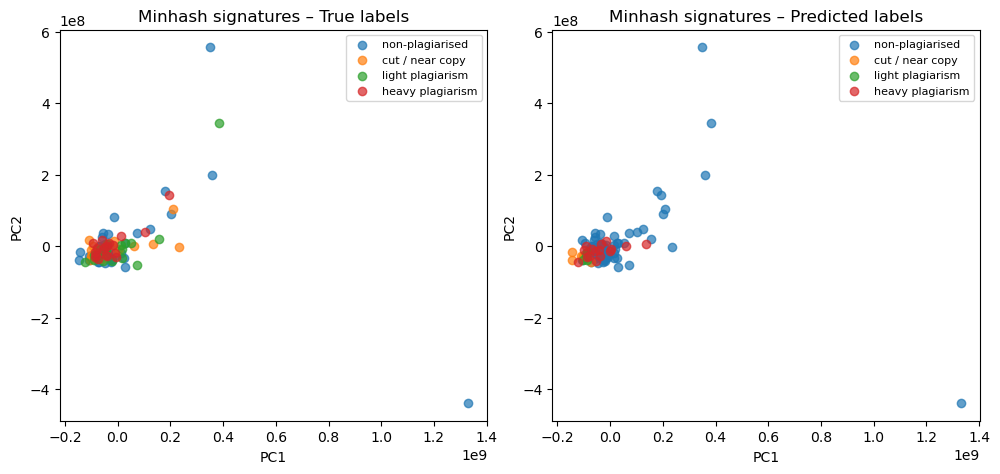

In [51]:
# 10) PCA visualisation of Minhash signatures
pca = PCA(n_components=2, random_state=42)
X_2d_mh = pca.fit_transform(mh_signatures)

plt.figure(figsize=(10, 5))

# Left: coloured by true plagiarism level
plt.subplot(1, 2, 1)
for lab in labels:
    mask = summary_data["true_plagiarism_level"] == lab
    plt.scatter(X_2d_mh[mask, 0], X_2d_mh[mask, 1], label=lab, alpha=0.7)
plt.title("Minhash signatures – True labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(fontsize=8)

# Right: coloured by Minhash predictions
plt.subplot(1, 2, 2)
for lab in labels:
    mask = summary_data["mh_predicted_plagiarism_level_tuned"] == lab
    plt.scatter(X_2d_mh[mask, 0], X_2d_mh[mask, 1], label=lab, alpha=0.7)
plt.title("Minhash signatures – Predicted labels")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()
